# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string

# import GloVe - for word embedding
from torchtext.vocab import GloVe
global_vectors = GloVe(name='840B', dim=300)

# tokenizer
from torchtext.data import get_tokenizer

# stop word removal
nltk.download('stopwords')
from nltk.corpus import stopwords

# lemmazation
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nunomachado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nunomachado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data pre-pocessing

Reading data from txt

In [2]:
df = pd.read_csv('train.txt', delimiter='\t', header=None, names=["Label", "Review"])
df_test = pd.read_csv('test_just_reviews.txt', delimiter='\t', header=None, names=["Review"])

#separating the labels into real/fake and positive/negative
df['Realness'] = df['Label'].str[:-8]
df['Sentiment'] = df['Label'].str[-8:]
df = df.drop('Label', axis=1)

# remove capitalized letters
#df['Review'] = df['Review'].str.lower()
#df['Review'] = tokenizer(df['Review'])
data = df.to_numpy()
Xt = df_test.to_numpy()[:,0]

X = data[:,0]
yr = data[:,1]
ys = data[:,2]
print(df)

                                                 Review   Realness Sentiment
0     The sheraton was a wonderful hotel! When me an...   TRUTHFUL  POSITIVE
1     We stayed at the Omni between Christmas and Ne...   TRUTHFUL  POSITIVE
2     I was REALLY looking forward to a nice relaxin...  DECEPTIVE  NEGATIVE
3     First let me say, I try not to be too critical...   TRUTHFUL  NEGATIVE
4     The Ambassador East Hotel is a terrible place ...  DECEPTIVE  NEGATIVE
...                                                 ...        ...       ...
1395  I stayed here for 5 nights last summer. I book...   TRUTHFUL  NEGATIVE
1396  Stayed here for 3 nights for a Bridgestone/Fir...   TRUTHFUL  POSITIVE
1397  I am staying here now and actually am compelle...   TRUTHFUL  NEGATIVE
1398  We stayed at this hotel with our two teenage d...   TRUTHFUL  NEGATIVE
1399  The rooms were beautiful! The staff was friend...  DECEPTIVE  POSITIVE

[1400 rows x 3 columns]


### pre processign functions

for stats

In [3]:
# takes array of reviews and prints statistics about both it
def reviews_stats(X, stop_word_rm = False, punctuation_rm = False):
    tam = []

    #tokenizing
    tokenizer = get_tokenizer("basic_english") 
    X = [tokenizer(x) for x in X]

    # stop words
    stop_words = set(stopwords.words('english'))

    if stop_word_rm == True:

        X_stop = []
        for x in X:
            X_stop.append([i for i in x if i not in stop_words])

        X = X_stop

    if punctuation_rm == True:

        X_stop = []
        for x in X:
            X_stop.append([i for i in x if i not in string.punctuation])
            
        X = X_stop

    #getting max numer of tokens in one review
    tam = []
    for x in X:
        tam.append(len(x))

    tam = np.array(tam)
    

    print(f"----- stats -----")

    print(f"tam_min-->{np.min(tam)}")
    print(f"tam_MAX-->{np.max(tam)}")
    print(f"tam_avg-->{np.average(tam)}")
    print(f"tam_median-->{np.median(tam)}")

    # distribuição do numero de palavras por review
    plt.hist(tam)
    plt.show()

    return tam, np.max(tam)

for the actual preprocessing

In [4]:
# Function that pre processes array of reviews
# if boolean=False it's a simple pre-processing (tokenization, padding and embedding)
# if false, lemmazation and stop word and pucntuation removal are also performed
def pp_x(X, stop_word_rm_lemma = True, max_words = 380):

    #tokenizing
    tokenizer = get_tokenizer("basic_english") 
    X = [tokenizer(x) for x in X]

    #print(f"after tokenization: X[0]-->{X[0]}")

    if stop_word_rm_lemma == True:

        # lemmazation
        wnl = WordNetLemmatizer()

        # stop word removal (and punctuation)
        stop_words = set(stopwords.words('english'))

        # apply both stop word removal and lemmazation
        X_stop = []
        for x in X:
            X_stop.append([wnl.lemmatize(i) for i in x if i not in stop_words and i not in string.punctuation])

        X = X_stop

    #print(f"after stop word and lemma: X_stop[0]-->{X_stop[0]}")
    print(f"max_words-->{max_words}")
    #print(f"type(X_stop[0])-->{type(X_stop[0])}")

    #padding
    X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]

    #print(f"after padding: X_stop[0]-->{X_stop[0]}")

    #embeddings
    X_emb = []
    for token in X:
        # tokenize and use glove word embedding
        X_emb.append(np.array(global_vectors.get_vecs_by_tokens(token)))

    X_emb = np.array(X_emb)

    #print(f"after embedding: X_emb[0]-->{X_emb[0]}")
    print(f"X_emb.shape-->{X_emb.shape}")

    return X_emb

----- stats -----
tam_min-->28
tam_MAX-->864
tam_avg-->168.855
tam_median-->145.0


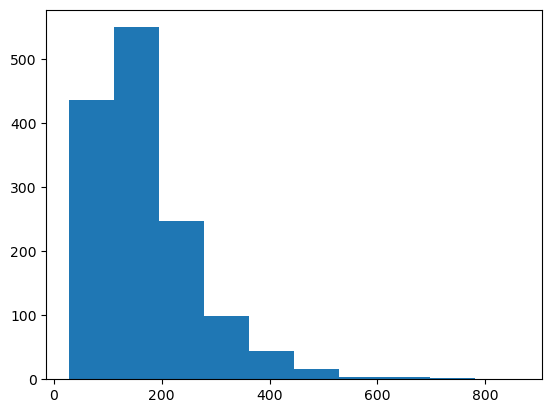

----- stats -----
tam_min-->39
tam_MAX-->868
tam_avg-->169.495
tam_median-->148.5


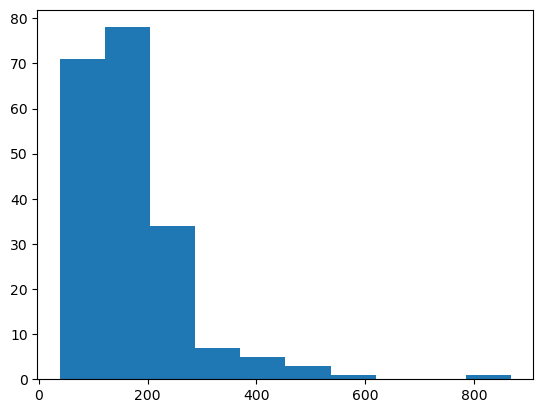

--
----- stats -----
tam_min-->13
tam_MAX-->380
tam_avg-->73.12
tam_median-->63.0


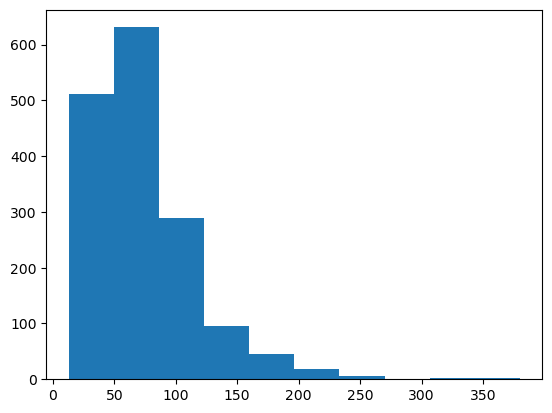

--


In [5]:
reviews_stats(X)
reviews_stats(Xt)
print("--")
X_all = np.concatenate((X,Xt), axis=0)
reviews_stats(X_all, True, True)
print("--")

In [6]:
X_pp = pp_x(X, stop_word_rm_lemma = True, max_words = 380)
Xt_pp = pp_x(Xt, stop_word_rm_lemma = True, max_words = 380)

X_emb = pp_x(X, stop_word_rm_lemma = True, max_words = 868)
Xt_emb =  pp_x(Xt, stop_word_rm_lemma = True, max_words = 868)

max_words-->380
X_emb.shape-->(1400, 380, 300)
max_words-->380
X_emb.shape-->(200, 380, 300)
max_words-->868
X_emb.shape-->(1400, 868, 300)
max_words-->868
X_emb.shape-->(200, 868, 300)


labels preprocessing

In [7]:
# simple conversion to 0'a and 1's for the
# deceptivness (1=truthful) and sentiment (1=positive)
for i in range(len(ys)):
    if ys[i] == "POSITIVE":
        ys[i] = 1
    else:
        ys[i] = 0

    if yr[i] == "TRUTHFUL":
        yr[i] = 1
    else:
        yr[i] = 0

ys = np.array(ys)
yr = np.array(yr)

testing dimensions

In [8]:
print(f"type(X_emb)-->{type(X_emb)}")
print(f"type(Xt_emb)-->{type(Xt_emb)}")
print(f"type(ys)-->{type(ys)}")
print(f"type(yr)-->{type(yr)}\n")

print(f"X_emb.shape-->{X_emb.shape}")
print(f"Xt_emb.shape-->{Xt_emb.shape}")
print(f"ys.shape-->{ys.shape}")
print(f"yr.shape-->{yr.shape}")

type(X_emb)--><class 'numpy.ndarray'>
type(Xt_emb)--><class 'numpy.ndarray'>
type(ys)--><class 'numpy.ndarray'>
type(yr)--><class 'numpy.ndarray'>

X_emb.shape-->(1400, 868, 300)
Xt_emb.shape-->(200, 868, 300)
ys.shape-->(1400,)
yr.shape-->(1400,)


In [9]:
# delete cache
del(global_vectors)
#save processed numpy arrays
np.save("./processed_train/X_emb.npy", X_emb)
np.save("./processed_train/Xt_emb.npy", Xt_emb)
np.save("./processed_train/ys.npy", ys)
np.save("./processed_train/yr.npy", yr)

## more pre processed, lemmazation and stop word removal
np.save("./processed_train/X_pp.npy", X_pp)
np.save("./processed_train/Xt_pp.npy", Xt_pp)